In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/STOR565 Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
txt_size = 500
epochs = 50
mini_batch = 500

In [ ]:
df = pd.read_csv("MBTI 500.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106067 entries, 0 to 106066
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   posts   106067 non-null  object
 1   type    106067 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [ ]:
df.head(5)

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


In [ ]:
df_train = df.sample(frac=0.5, random_state=5).copy()
df_val_test = df.drop(df_train.index).copy()
df_val = df_val_test.sample(frac=0.5, random_state=5).copy()
df_test = df_val_test.drop(df_val.index).copy()

In [ ]:
labels_train = df_train['type'].values
data_train = df_train['posts'].values

labels_val = df_val['type'].values
data_val = df_val['posts'].values

labels_test = df_test['type'].values
data_test = df_test['posts'].values

le = LabelEncoder()
en_labels_train = le.fit_transform(labels_train)
en_labels_val = le.transform(labels_val)
en_labels_test = le.transform(labels_test)

Text(0.5, 1.0, 'Count of types')

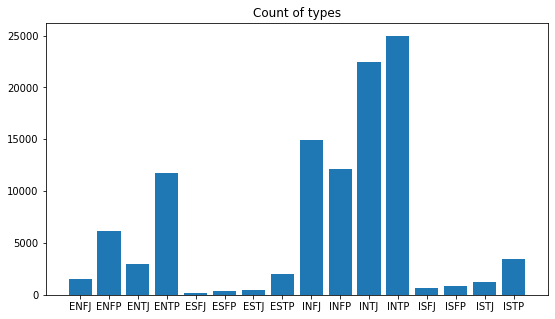

In [ ]:
unique_labels, count = np.unique(df['type'], return_counts=True)
fig = plt.figure(figsize=(9,5))
plt.bar(unique_labels, count, width=0.8)
plt.title("Count of types")

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(data_train)

In [ ]:
def pad_data(tokenizer, data2pad, maxlen):
  sequence = tokenizer.texts_to_sequences(data2pad)
  paded = pad_sequences(sequence, truncating='post', padding='post', 
                                 maxlen=maxlen)
  return paded

In [ ]:
paded_data_train = pad_data(tokenizer, data_train, txt_size)
paded_data_val = pad_data(tokenizer, data_val, txt_size)
paded_data_test = pad_data(tokenizer, data_test, txt_size)

In [ ]:
paded_data_train.shape

(53034, 500)

In [ ]:
def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1) 
    return vectorize_layer(text), label 
# Vectorize the data. 

max_features = 10000
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_features, 
    output_mode="int", 
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(data_train)
vect_train = vectorize_layer(data_train)
vect_val = vectorize_layer(data_val)
vect_test = vectorize_layer(data_test)

In [ ]:
def create_model1(post_size, num_labels):
    model = Sequential([
            # The input layer
            layers.Embedding(10000, 32, input_length=post_size),
            layers.Bidirectional(layers.LSTM(40, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(40)),
            layers.Dense(num_labels, activation='softmax')  
    ])
    return model


In [ ]:
model1_token = create_model1(txt_size, len(unique_labels))
model1_token.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model1_token.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 80)          23360     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80)               38720     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1296      
                                                                 
Total params: 383,376
Trainable params: 383,376
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1_token.fit(
    paded_data_train, en_labels_train,
    validation_data = (paded_data_val, en_labels_val),
    epochs = epochs,
    batch_size = mini_batch,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/50
107/107 [==============================] - 24s 163ms/step - loss: 2.1964 - accuracy: 0.2239 - val_loss: 2.0892 - val_accuracy: 0.2304
Epoch 2/50
107/107 [==============================] - 16s 148ms/step - loss: 2.0364 - accuracy: 0.2406 - val_loss: 2.0278 - val_accuracy: 0.2421
Epoch 3/50
107/107 [==============================] - 16s 149ms/step - loss: 1.9957 - accuracy: 0.2542 - val_loss: 2.0265 - val_accuracy: 0.2485
Epoch 4/50
107/107 [==============================] - 16s 145ms/step - loss: 1.9398 - accuracy: 0.2826 - val_loss: 2.0002 - val_accuracy: 0.2663
Epoch 5/50
107/107 [==============================] - 16s 147ms/step - loss: 1.8067 - accuracy: 0.3341 - val_loss: 1.8847 - val_accuracy: 0.3036
Epoch 6/50
107/107 [==============================] - 16s 146ms/step - loss: 1.6385 - accuracy: 0.3961 - val_loss: 1.6887 - val_accuracy: 0.3820
Epoch 7/50
107/107 [==============================] - 16s 148ms/step - loss: 1.6408 - accuracy: 0.3946 - val_loss: 1.6868 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


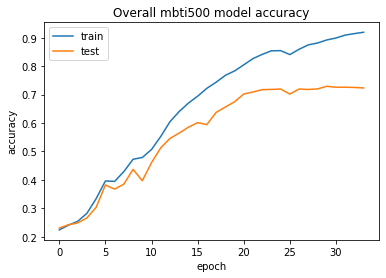

In [ ]:
import keras
from matplotlib import pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Overall mbti500 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Overall mbti500 model accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

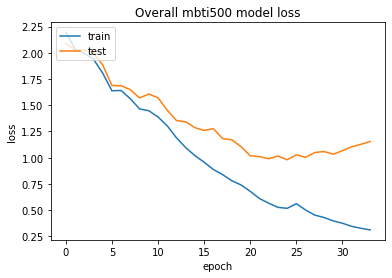

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Overall mbti500 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Overall mbti500 model loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
_ = model1_token.evaluate(paded_data_test, en_labels_test)

829/829 [==============================] - 22s 26ms/step - loss: 1.1627 - accuracy: 0.7205
